# Predicting AQI in California
## Data200 Grad Project

### Madelyn Payne, Mingyu Yuan, Yukun Zhang

This project consists of the following six sections:
1. Introduction
2. EDA
3. PCA
4. Linear Regression Model
5. Machine Learning Model
6. Discussion

A. Supplementary Logistical Regression Model

# 1. Introduction

The air quality index (AQI) is an important metric used to determine how clean the air is and how concerned people should be about breathing in pollutants. AQI may correspond to wildfire frequency at certain times and locations. In our project, we use data collected by the United States Environmental Protection Agency (EPA), which include daily AQI values, coordinates of measurement locations, measurements of individual pollutants, and more. 

We aim to accurately predict the AQI level in a particular location given various known features such as the no2 values, s02 values, ozone values, temperature, and wind. Using linear regression models we observe both a training and test RMSE around 16. An error this small will allow any reader to ascertain their health risk because levels of concern are separated by 50 or more AQI points. Furthermore, using a neural network machine learning model, we observe similar training and testing RMSE values. We conclude that our model reasonably predicts AQI values at least within a range of hazard levels. Our secondary conclusion is that the extra computational power required for a machine learning model is not necessary nor beneficial for solving this problem. We also present an alternative way to predict health hazard (using the same features as above) via a logistical regression model that predicts the level of concern outright. This exploration can be found in the supplementary materials. 


# 2. EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd
from pathlib import Path
import pathlib
import os
import requests, zipfile, io
import plotly

import warnings
warnings.filterwarnings('ignore')

## 2.1 Load the data

In [2]:
#works on linux machines!!
epa_data = {}
for root,dirs, files in os.walk(".",topdown=True):
    for name in files:
        if name[-4:] == ".csv":
            path = os.path.join(root, name)
            data = pd.read_csv(path)
            # print(path)
            if "./AQI_Data/" in root:
                pattern = r"./AQI_Data/(\w+)/\w+.csv"
                ls_match = re.findall(pattern,str(path))
                if "/.ipynb" not in root:
                    # print(ls_match)
                    name = ls_match[0]
                    epa_data[name] = data
            else:
                epa_data[name[:-4]] = data
epa_data.keys();#check keys are correct

In [ ]:
#works for windows!!
epa_data = {}
for root,dirs, files in os.walk(".",topdown=True):
    root_old = root
    p = pathlib.Path(root_old)
    root = p.as_posix()
#     print('root: '+root)
    for name in files:
#         print('name: '+name)
        if name[-4:] == ".csv":
            path = os.path.join(root_old, name)
            data = pd.read_csv(path)
#             print('path: '+path)
            if ".\\AQI_Data\\" in root_old:
                pattern = r".\\AQI_Data\\(\w+)\\\w+.csv"
                ls_match = re.findall(pattern,str(path))
                if "/.ipynb" not in root:
                    print(ls_match)
                    name = ls_match[0]
                    epa_data[name] = data
            else:
                epa_data[name[:-4]] = data
epa_data.keys();#check keys are correct

In [3]:
#add month and day to daily_county_aqi; df daily_county changes the object in the epa_data dictionary
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.to_datetime(daily_county['Date']).dt.month
daily_county['Day'] = pd.to_datetime(daily_county['Date']).dt.day

In [4]:
#exclude all tables that don't have 'State Name'
epa_data_CA = {}
keep_out = ['annual_county_aqi','aqs_sites','us_air_quality_measures','us_greenhouse_gas_emission_direct_emitter_gas_type',\
            'us_greenhouse_gas_emissions_direct_emitter_facilities','daily_global_weather_2020','2021','epa_filenames','Traffic_Volumes_AADT']
for table in list(epa_data):
    if table in keep_out:
        continue
    elif 'State Name' not in epa_data[table].keys():
        pass
        # print(table)
        # print(epa_data[table].head())
    else:
        epa_data_CA[table] = epa_data[table][epa_data[table]["State Name"] == 'California']

# epa_data_CA.get('daily_county_aqi').head()

In [5]:
#merge daily_county_aqi with aqs_sites for CA based on FIPs number
cols = ['State Name', 'County Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']
epa_data['aqs_sites']['a'] = epa_data['aqs_sites']['State Code'].astype(str).str.zfill(2)
epa_data['aqs_sites']['b'] = epa_data['aqs_sites']['County Code'].astype(str).str.zfill(3)
epa_data['aqs_sites']['c'] = epa_data['aqs_sites']['Site Number'].astype(str).str.zfill(4)
epa_data['aqs_sites']['Defining Site'] = epa_data['aqs_sites']['a'] + '-' + epa_data['aqs_sites']['b'] + '-' + epa_data['aqs_sites']['c']
epa_data_CA_merged = epa_data_CA['daily_county_aqi'].merge(epa_data['aqs_sites'], how='left', left_on='Defining Site', right_on='Defining Site', suffixes=('', '_y'))[cols]

# epa_data_CA_merged.head(2)

## 2.2 AQI over time

In [6]:
aqi_per_month = epa_data['daily_county_aqi'].groupby("Month").mean()["AQI"]
aqi_per_month_CA = epa_data_CA['daily_county_aqi'].groupby("Month").mean()["AQI"]
aqi_per_month = aqi_per_month.rename('AQI_all')
aqi_per_month_CA = aqi_per_month_CA.rename('AQI_CA')
aqi_per_month_df = pd.concat([aqi_per_month,aqi_per_month_CA], axis=1)
aqi_per_month_df = aqi_per_month_df.reset_index()

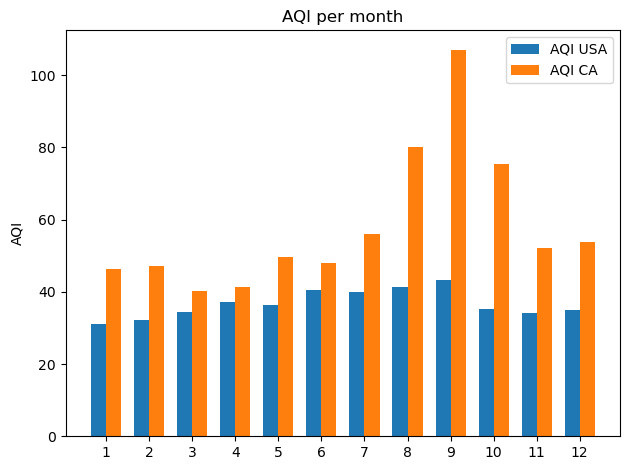

In [7]:
labels = ['1', '2', '3', '4', '5','6','7','8','9','10','11','12']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, aqi_per_month, width, label='AQI USA')
rects2 = ax.bar(x + width/2, aqi_per_month_CA, width, label='AQI CA')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AQI')
ax.set_title('AQI per month')
ax.set_xticks(x, labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

We can see that the average AQI per month in the state of california is on average higher than the average for all US states. This is probably because CA has more wildfires on average compared to the rest of the USA. 

## 2.3 Visualization of AQI

In [8]:
import geopandas as gpd
import mapclassify
import geoplot as gplt

In [9]:
# Create CA geodataframe
states =['California']
usa = gpd.read_file("https://raw.githubusercontent.com/danhammer/envirods/main/data/gz_2010_us_040_00_20m.geojson")
state_gdf = usa[usa.NAME.isin(states)]
# Load CA county coordinates and create county geodataframe
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

geoData = geoData[geoData.STATE.isin(['06'])]

# pass in a dataframe with three columns: Longtitude, Latitude, AQI/Residual
# color = True (color-code AQI); color = False (show heatmap)
# title = title for plot
# county_lines_on: True or False for including county lines
def heatmap_cl(df,title,county_lines_on,color):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    fig, ax = plt.subplots(figsize=(10,7))
    if county_lines_on:
        geoData.plot(
            ax=ax,
            column = 'AQI',
            color="lightgrey",
            edgecolor="white")
    else:
        state_gdf.plot(
        ax=ax,
        color="lightgrey",
        edgecolor="white")
    ax.title.set_text(title)
    plt.xticks([],[])
    plt.yticks([],[])
    if color == False: 
        gdf.plot(ax=ax,column=gdf.iloc[:,-2], cmap = 'inferno', scheme='Percentiles', legend=True);
    else: 
        from matplotlib import colors
        cmap = colors.ListedColormap(['Green','Yellow','Orange','Red','Purple','Maroon'])
        bounds = [0,50,100,150,200,300,2000]
        norm = colors.BoundaryNorm(bounds,cmap.N)
        gdf.plot(ax=ax,column=gdf.iloc[:,-2],cmap = cmap,norm=norm,legend=True);

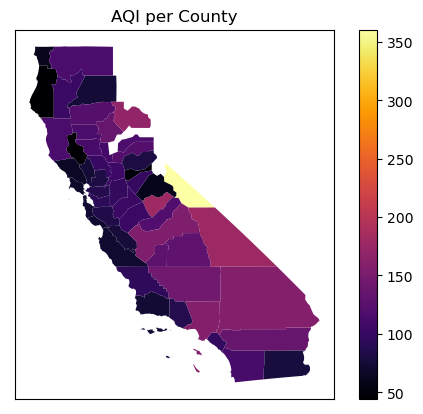

In [10]:
###plot county AQI and level of concern data
coords2 = epa_data_CA_merged[epa_data_CA_merged['Month']==9][['Longitude','Latitude','AQI','County Name']]
coords2 = coords2[['County Name','AQI']].groupby('County Name').mean()
coords2=coords2.reset_index()
full_data2 = geoData.merge(coords2[['County Name','AQI']],left_on='NAME',right_on='County Name')
full_data2.head(2)
fig, ax = plt.subplots()
full_data2.plot(
    ax=ax,
    column='AQI',cmap = 'inferno',legend=True);
ax.title.set_text('AQI per County')
plt.xticks([],[])
plt.yticks([],[])
plt.show()

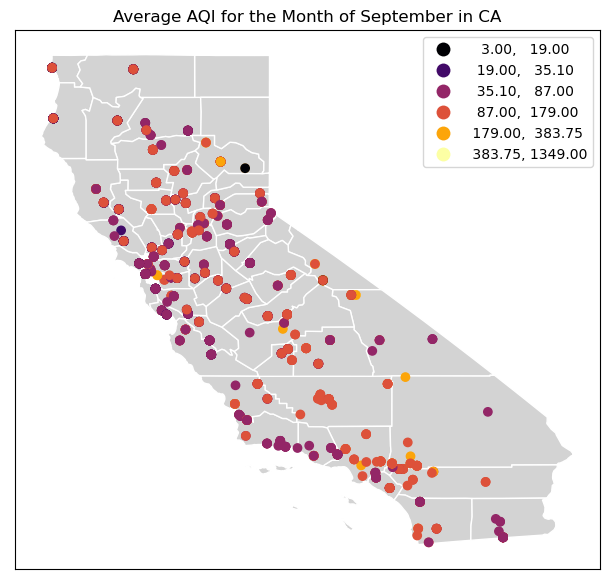

In [11]:
coords = epa_data_CA_merged[epa_data_CA_merged['Month']==9][['Longitude','Latitude','AQI']]
title = 'Average AQI for the Month of September in CA'
heatmap_cl(coords,title,True, False)

Wildfires can be a significant influence on AQI<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) and in CA, September and October are considered the most vulnerable months of wildfire season<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2). For these reasons, we plot the AQI values collected across the state for the month of September at individual AQI measuring locations. This plot is used to visualize how AQI differs in different regions. The lighter colored dots are found further away from the coast. This makes sense as these typically mountainous regions with lots of vegetation in eastern California are historically affected by wildfires.
<br />
<a name="cite_note-1"></a>1. [^](#cite_ref-1) https://www.epa.gov/wildfire-smoke-course/wildfire-smoke-and-your-patients-health-air-quality-index
<a name="cite_note-2"></a>2. [^](#cite_ref-2) https://www.frontlinewildfire.com/wildfire-news-and-resources/california-fire-season/

California counties shown on the right - San Bernardino, Los Angeles, Riverside - experienced much worse air quality with median AQI ranging from 80 to 95. On the left side of the plot, counties such as Del Norte and Trinity had very good air quality overall, with median. On the right compared to counties on the left such as Del Norte and Trinity, which had median AQI ranging from 28 to 32.

We can also plot the AQI values by Levels of Concern. AQI is divided into six categories, where each category corresponds to a different level of health concern, ranging from Good to Hazardous, as shown in the table from https://www.airnow.gov/aqi/aqi-basics/.

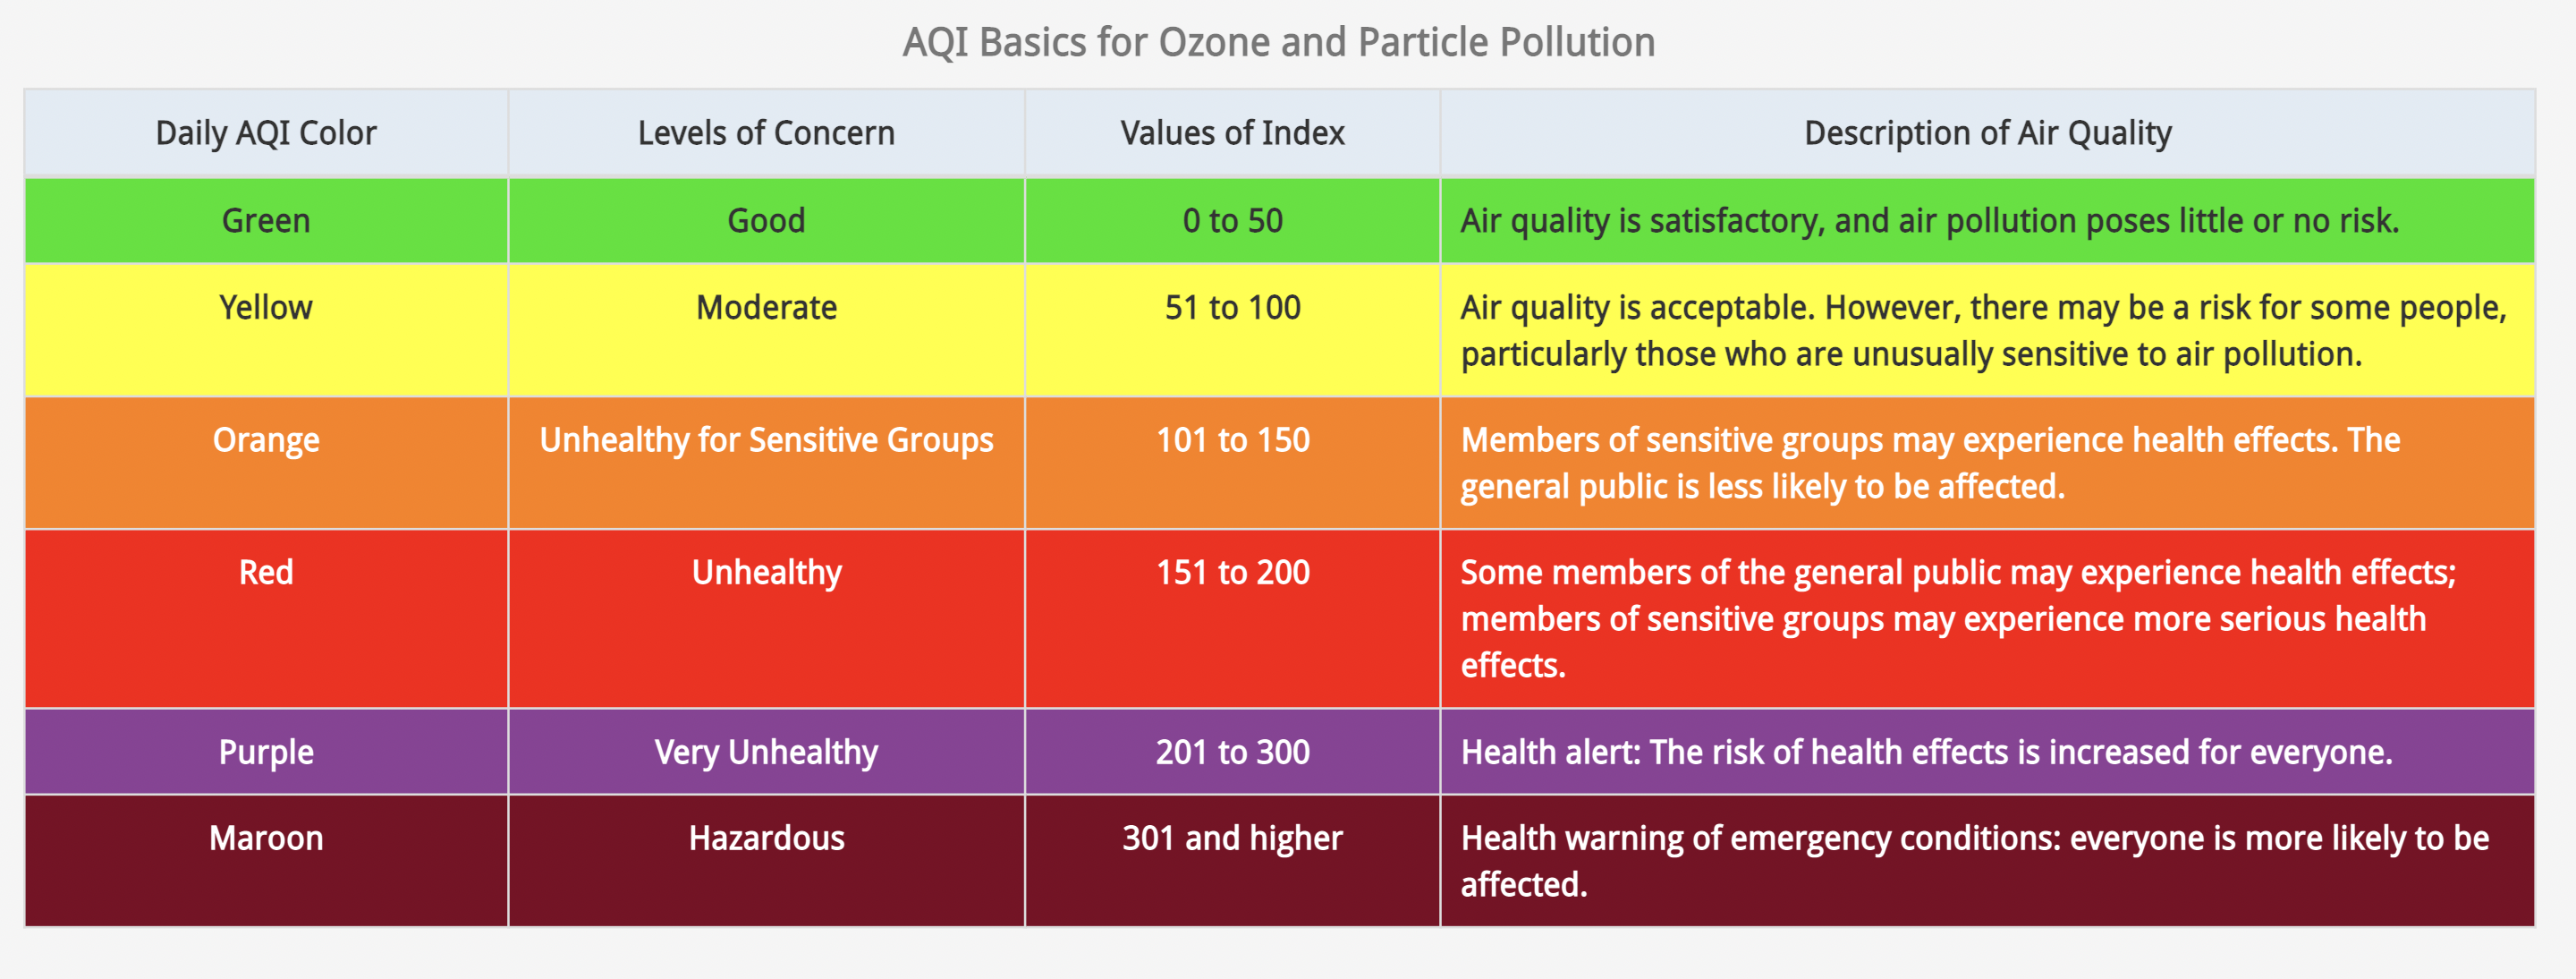

Below we can show AQI level of concern by CA county for the month of September in 2020. We can more clearly see in this plot that although 

In [12]:
levelsOfConcern = ['Good','Moderate','Unhealthy for Sensitive Groups','Unhealthy','Very Unhealthy','Hazardous']

In [13]:
levelsOfConcern_cbr = ['','Good','Moderate','Unhealthy for Sensitive Groups','Unhealthy','Very Unhealthy','Hazardous','']
#https://www.airnow.gov/aqi/aqi-basics/

In [14]:
from matplotlib import colors
def colorbar():
    #make a color map of fixed colors
    cmap = colors.ListedColormap(['Green','Yellow','Orange','Red','Purple','Maroon'])
    bounds = [0,50,100,150,200,300,2000]
    norm = colors.BoundaryNorm(bounds,cmap.N)
    cax = fig.add_axes([1, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbr = fig.colorbar(sm, cax=cax)
    cbr.set_ticks([bounds[0]] + [(b0 + b1) / 2 for b0, b1 in zip(bounds[:-1], bounds[1:])] + [bounds[-1]])
    levelsOfConcern_cbr = ['','Good','Moderate','Unhealthy for Sensitive Groups','Unhealthy','Very Unhealthy','Hazardous','']
    #https://www.airnow.gov/aqi/aqi-basics/
    tick_texts = cbr.ax.set_yticklabels(levelsOfConcern_cbr)
    tick_texts[0].set_verticalalignment('top')
    tick_texts[-1].set_verticalalignment('bottom')
    cbr.ax.tick_params(length=0) # optionally remove the tick marks


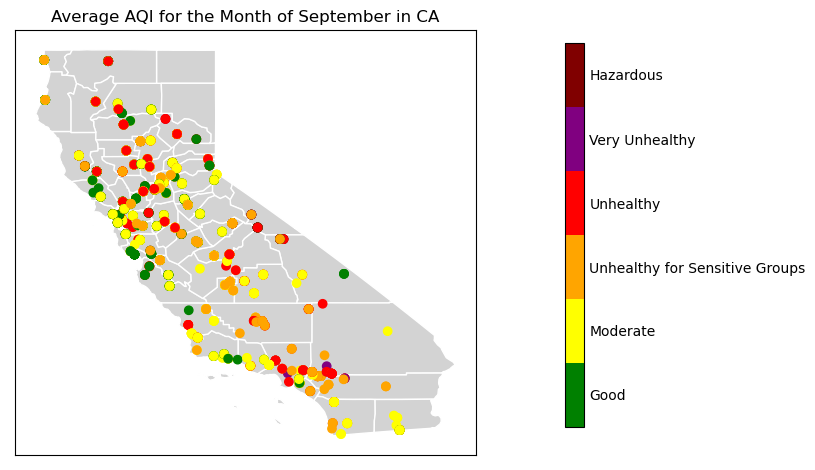

In [15]:
title = 'Average AQI for the Month of September in CA'
fig, ax = plt.subplots()
geoData.plot(
    ax=ax,
    column='AQI',color='lightgrey',edgecolor='white');
ax.title.set_text(title)
plt.xticks([],[])
plt.yticks([],[])
#make a color map of fixed colors
cmap = colors.ListedColormap(['Green','Yellow','Orange','Red','Purple','Maroon'])
bounds = [0,50,100,150,200,300,2000]
norm = colors.BoundaryNorm(bounds,cmap.N)
df = coords
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf.plot(ax=ax,column=gdf.AQI,cmap = cmap,norm=norm,legend=False);
colorbar()
plt.tight_layout()
plt.show()

We can even condense this to show level of concern by county, which could get rid of issues of overplotting

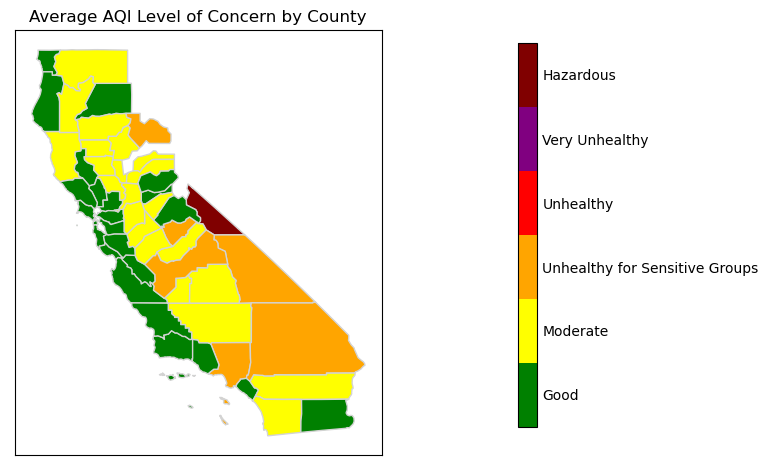

In [86]:
#This is the AQI by county hazardous levels
from matplotlib import colors
#make a color map of fixed colors
cmap = colors.ListedColormap(['Green','Yellow','Orange','Red','Purple','Maroon'])
bounds = [0,50,100,150,200,300,2000]
norm = colors.BoundaryNorm(bounds,cmap.N)

fig, ax = plt.subplots()
full_data2.plot(
    ax=ax,
    column='AQI',edgecolor='lightgrey',
    cmap = cmap,legend=False);
ax.title.set_text('Average AQI Level of Concern by County')
plt.xticks([],[])
plt.yticks([],[])

cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.set_ticks([bounds[0]] + [(b0 + b1) / 2 for b0, b1 in zip(bounds[:-1], bounds[1:])] + [bounds[-1]])
tick_texts = cbr.ax.set_yticklabels(levelsOfConcern_cbr)
tick_texts[0].set_verticalalignment('top')
tick_texts[-1].set_verticalalignment('bottom')
cbr.ax.tick_params(length=0) # optionally remove the tick marks
plt.tight_layout()
plt.show()

## 2.4 Missing AQI Data

In [17]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data['Days with AQI'].sort_values()
ca_aqi_days.head(5)

54    274
96    331
63    351
98    353
49    359
Name: Days with AQI, dtype: int64

In [18]:
county_to_missing_dates = {}
interested = ca_aqi_days[ca_aqi_days != 366]

for idx in interested.index:
    county = ca_annual_data.loc[idx]['County']
    evaluate = epa_data_CA['daily_county_aqi'][epa_data_CA['daily_county_aqi']['county Name'] == county]
    evaluate.set_index('Date',inplace=True)
    evaluate.index = pd.to_datetime(evaluate.index)
    dates = pd.date_range(start = '2020-01-01',end='2020-12-31').difference(evaluate.index).strftime('%Y-%m-%d')
    county_to_missing_dates[county] = dates

county_to_missing_dates

{'Del Norte': Index(['2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18', '2020-01-20',
        '2020-01-21', '2020-01-23', '2020-03-14', '2020-03-15', '2020-04-22',
        '2020-04-23', '2020-04-25', '2020-04-26', '2020-04-28', '2020-04-29',
        '2020-05-01', '2020-05-02', '2020-05-04', '2020-05-05', '2020-05-07',
        '2020-05-08', '2020-05-10', '2020-05-11', '2020-05-13', '2020-05-14',
        '2020-05-16', '2020-05-17', '2020-05-19', '2020-05-20', '2020-05-22',
        '2020-05-23', '2020-05-25', '2020-05-26', '2020-05-28', '2020-05-29',
        '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
        '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
        '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
        '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
        '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
        '2020-06-25', '2020-06-26', '2020-06-27', '

We also take a look at the coverage of the annual aqi data for 2020. 2020 was a leap year with 366 days. It appears that many counties had aqi values recorded for every day of the year, but some counties had fewer. Not all CA counties were represented in the annual_county_aqi data (53 accounted for) and of those represented the lowest number of days recorded was 274 days. Looking more closely at the counties with less than all days recorded. Major missing dates in common between counties are: February 29, 2020 (Count = 3), as well as July 1, 2020 through July 14, 2020.  Del Norte and Trinity counties had the most missing dates, perhaps because the wildfires occuring in those counties had some AQI values omitted.

## 2.5 Missing feature data

For this project, we are interested to know pollutants and other weather-related features (i.e. temperature and wind) would predict AQI. We include all of the data in the ``AQI_Data`` folder except the traffic volume data. They are:
- SO2
- NO2
- CO
- Ozone
- Temperature 
- Wind
We include the list of features we are interested in looking at in the list ``preds``:

In [19]:
preds = ['daily_so2', 'daily_no2', 'daily_co', 'daily_ozone', "daily_temp", "daily_wind"]

We first inspect each feature to see if we have daily data for every county in california. We pass all features we are interested in to a list called ``preds``. For each feature, the original dataset has a range of measures and results, typically including:

- Observation Count
- Observation Percent
- Arithmetic Mean
- 1st Max Value
- 1st Max Hour

The complete list of columns of each dataset is shown in the code cell below. For this project, we are interested to know if ``AQI (of the pollutant)``, ``Arithmetic Mean``, and ``1st Max Value`` would contribute to the prediction of AQI. We include these measures in the list ``cols``.

In [20]:
print(epa_data[preds[0]].loc[epa_data[preds[0]]['State Name'] == 'California'].columns)
cols = ['County Name', 'Date Local', 'AQI', 'Arithmetic Mean', '1st Max Value']

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Date Local', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 'Arithmetic Mean',
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')


Next, we inspect the feature in details. It looks like that we have multiple datapoints per day for some county. For instance, on Jan 1st 2020, Alameda has two observations of SO2. Instead of feeding all of them into the model, we decided to impute the data to get the mean of daily observations, if there are any. 

In [21]:
epa_data[preds[0]].loc[epa_data[preds[0]]['State Name'] == 'California'][cols].groupby(['County Name','Date Local']).size()

County Name  Date Local
Alameda      2020-01-01    2
             2020-01-02    2
             2020-01-03    2
             2020-01-04    2
             2020-01-05    2
                          ..
Solano       2020-12-27    2
             2020-12-28    2
             2020-12-29    2
             2020-12-30    2
             2020-12-31    2
Length: 5466, dtype: int64

Futhermore, it seems that we do not have SO2 data for all counties, only the following 15.

In [22]:
epa_data[preds[0]].loc[epa_data[preds[0]]['State Name'] == 'California'][cols].groupby(['County Name','Date Local']).size().index.get_level_values(0).unique()

Index(['Alameda', 'Contra Costa', 'Fresno', 'Humboldt', 'Imperial', 'Inyo',
       'Los Angeles', 'Riverside', 'Sacramento', 'San Bernardino', 'San Diego',
       'San Luis Obispo', 'Santa Barbara', 'Santa Clara', 'Solano'],
      dtype='object', name='County Name')

We then inspect all features for all counties to see if (1) we have data of one particular feature for each county and (2) we have data of one particular feature for each day in the year 2020.

In [23]:
def get_feature_num(preds):
    county_dict = epa_data[preds[0]].loc[epa_data[preds[0]]['State Name'] == 'California'][cols].groupby(['County Name','Date Local']).count().iloc[:,0].unstack().to_dict(orient='index')
    res = {k:len(v) for k,v in county_dict.items()}
    df = pd.DataFrame(res.items(), columns=['County', preds[0]]) 
    for pred in preds[1:]:
        county_dict = {}
        res = {}
        county_dict = epa_data[pred].loc[epa_data[pred]['State Name'] == 'California'][cols].groupby(['County Name','Date Local']).count().iloc[:,0].unstack().to_dict(orient='index')
        res = {k:len(v) for k,v in county_dict.items()}
        df_res = pd.DataFrame(res.items(), columns=['County', pred])
        df = pd.merge(df, df_res, how='outer')
    return df

It looks like we indeed have many missing values. For instance, we don't have daily temperature and wind data for Alameda.

In [24]:
get_feature_num(preds).head().style.applymap(lambda x: 'color: red' if pd.isna(x) else '')

,County,daily_so2,daily_no2,daily_co,daily_ozone,daily_temp,daily_wind
0,Alameda,366.000000,366.000000,366.000000,366.000000,nan,nan
1,Contra Costa,366.000000,366.000000,366.000000,366.000000,nan,nan
2,Fresno,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
3,Humboldt,366.000000,366.000000,366.000000,366.000000,nan,nan
4,Imperial,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000


We can have an overview of data we have by getting rid of all missing values; and we end up with nine counties that have all data of all of the features we can use to predict AQI.

In [25]:
get_feature_num(preds).dropna().reset_index(drop=True)

,County,daily_so2,daily_no2,daily_co,daily_ozone,daily_temp,daily_wind
0,Fresno,366.0,366.0,366.0,366.0,366.0,366.0
1,Imperial,366.0,366.0,366.0,366.0,366.0,366.0
2,Los Angeles,366.0,366.0,366.0,366.0,366.0,366.0
3,Riverside,366.0,366.0,366.0,366.0,366.0,366.0
4,Sacramento,366.0,366.0,366.0,366.0,366.0,366.0
5,San Bernardino,366.0,366.0,366.0,366.0,366.0,366.0
6,San Diego,366.0,366.0,366.0,366.0,366.0,366.0
7,Santa Barbara,366.0,366.0,366.0,366.0,366.0,366.0
8,Santa Clara,366.0,366.0,366.0,366.0,366.0,366.0


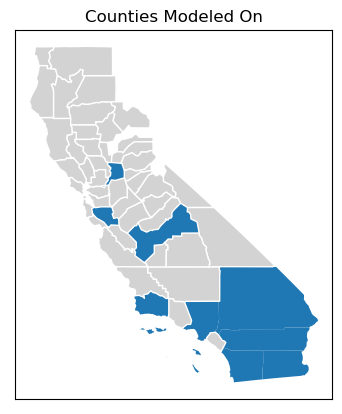

In [88]:
### the counties we have all the features for
valid_counties=['Fresno', 'Imperial', 'Los Angeles', 'Riverside', 'Sacramento',
       'San Bernardino', 'San Diego', 'Santa Barbara', 'Santa Clara']
#i should try to visualize this
full_data3 = full_data2[full_data2.NAME.isin(valid_counties)]
left_over = full_data2[~full_data2.NAME.isin(valid_counties)]
fig, ax = plt.subplots()
full_data3.plot(
    ax=ax,legend=True);
left_over.plot(
    ax=ax,
    column='AQI',color='lightgrey',edgecolor='white');

ax.title.set_text('Counties Modeled On')
plt.xticks([],[])
plt.yticks([],[])
plt.show()

## 2.6 Combine feature data with AQI

Now we now what's missing in the AQI data and feature data. The next step is to combine both AQI and feature data into a single dataframe for modelling. We first split time in ``epa_data_CA_merged`` into three columns: ``year``, ``month``, and ``day``, which would be the index column later we will use to merge data by.

In [26]:
epa_data_CA_merged['year'] = '2020'
epa_data_CA_merged['Date Local'] = pd.to_datetime(epa_data_CA_merged[["year", 'Month', 'Day']])
epa_data_CA_merged['Date Local'] = epa_data_CA_merged['Date Local'].astype(str)
#epa_data_CA_merged['merge']=[i[0] + "_"+ i[1] for i in epa_data_CA_merged.index]
epa_data_CA_merged = epa_data_CA_merged.set_index(['County Name', 'Date Local'], inplace=False)
epa_data_CA_merged

State Name  Month  Day  AQI  Category Defining Site  \
County Name Date Local                                                        
Alameda     2020-01-01  California      1    1   53  Moderate   06-001-0009   
            2020-01-02  California      1    2   43      Good   06-001-0013   
            2020-01-03  California      1    3   74  Moderate   06-001-0013   
            2020-01-04  California      1    4   45      Good   06-001-0007   
            2020-01-05  California      1    5   33      Good   06-001-0007   
...                            ...    ...  ...  ...       ...           ...   
Yolo        2020-12-27  California     12   27   20      Good   06-113-0004   
            2020-12-28  California     12   28   33      Good   06-113-0004   
            2020-12-29  California     12   29   28      Good   06-113-0004   
            2020-12-30  California     12   30   39      Good   06-113-0004   
            2020-12-31  California     12   31   35      Good   06-113-0004   

                         Latitude   Longitude  year  
County Name Date Local                               
Alameda     2020-01-01  37.743065 -122.169935  2020  
            2020-01-02  37.864767 -122.302741  2020  
            2020-01-03  37.864767 -122.302741  2020  
            2020-01-04  37.687526 -121.784217  2020  
            2020-01-05  37.687526 -121.784217  2020  
...                           ...         ...   ...  
Yolo        2020-12-27  38.534450 -121.773400  2020  
            2020-12-28  38.534450 -121.773400  2020  
            2020-12-29  38.534450 -121.773400  2020  
            2020-12-30  38.534450 -121.773400  2020  
            2020-12-31  38.534450 -121.773400  2020  

[19225 rows x 9 columns]

We then get rid of other columns but only keep Month, AQI, Category, Latitute and Longitude.

In [27]:
epa_data_CA_merged[['Month', 'AQI','Category','Latitude','Longitude']]

Month  AQI  Category   Latitude   Longitude
County Name Date Local                                             
Alameda     2020-01-01      1   53  Moderate  37.743065 -122.169935
            2020-01-02      1   43      Good  37.864767 -122.302741
            2020-01-03      1   74  Moderate  37.864767 -122.302741
            2020-01-04      1   45      Good  37.687526 -121.784217
            2020-01-05      1   33      Good  37.687526 -121.784217
...                       ...  ...       ...        ...         ...
Yolo        2020-12-27     12   20      Good  38.534450 -121.773400
            2020-12-28     12   33      Good  38.534450 -121.773400
            2020-12-29     12   28      Good  38.534450 -121.773400
            2020-12-30     12   39      Good  38.534450 -121.773400
            2020-12-31     12   35      Good  38.534450 -121.773400

[19225 rows x 5 columns]

We will merge the above AQI data with the feature data (see the ``preds`` list). Each feature has its own ``.csv`` file so we will merge each feature data with the AQI data by ``County Name`` and ``Date Local``. 

In [28]:
preds = ['daily_so2', 'daily_no2', 'daily_co', 'daily_ozone', "daily_temp", "daily_wind"]
cols = ['County Name', 'Date Local', 'AQI', 'Arithmetic Mean', '1st Max Value']

def merge_data(preds, cols):
    #df = epa_data[preds[-1]].loc[epa_data[preds[-1]]['State Name'] == 'California']
    df = epa_data[preds[0]].loc[epa_data[preds[0]]['State Name'] == 'California'][cols].groupby(['County Name','Date Local']).agg(np.mean)[['AQI']]
    for pred in preds:
        df_ca = epa_data[pred].loc[epa_data[pred]['State Name'] == 'California'][cols].groupby(['County Name','Date Local']).agg(np.mean)
        df = df.join(df_ca, how='inner', rsuffix = pred[5:])
    df = df.drop(columns='AQI')
    return df

We call the merged data ``ca_whole`` and reset the index to numbers. 

In [29]:
ca_whole = epa_data_CA_merged[['Month', 'AQI','Category','Latitude','Longitude']].join(merge_data(preds, cols), how='inner')
ca_whole = ca_whole.rename(columns={'Arithmetic Mean': 'Arithmetic Mean_so2', '1st Max Value': '1st Max Value_so2'})
ca_whole = ca_whole.drop(columns=['AQI_wind', 'AQI_temp'])
ca_whole = ca_whole.reset_index()

In [30]:
ca_whole.head(2)

,County Name,Date Local,Month,AQI,Category,Latitude,Longitude,AQI_so2,Arithmetic Mean_so2,1st Max Value_so2,...,AQI_co,Arithmetic Mean_co,1st Max Value_co,AQI_ozone,Arithmetic Mean_ozone,1st Max Value_ozone,Arithmetic Mean_temp,1st Max Value_temp,Arithmetic Mean_wind,1st Max Value_wind
0,Fresno,2020-01-01,1,130,Unhealthy for Sensitive Groups,36.710833,-119.77750,0.0,0.129166,0.25,...,9.333333,0.563523,0.946333,23.833333,0.014519,0.025833,82.127344,171.8375,82.127344,171.8375
1,Fresno,2020-01-02,1,102,Unhealthy for Sensitive Groups,36.785380,-119.77321,0.0,0.052084,0.15,...,8.000000,0.520751,0.773167,18.166667,0.010873,0.019667,74.927604,169.6125,74.927604,169.6125


In [31]:
ca_whole.to_csv('ca_whole.csv')

# 3. PCA

In [33]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import plotly

In [34]:
ca_whole = pd.read_csv('ca_whole.csv',index_col=0)

In [35]:
# Drop Outlier
max_aqi = np.mean(ca_whole['AQI'])+2*np.std(ca_whole['AQI'])
min_aqi = np.mean(ca_whole['AQI'])-2*np.std(ca_whole['AQI'])
ca_whole = ca_whole.loc[ca_whole['AQI']<=max_aqi]

## 3.1 First do PCA for categorization

In [36]:
#how many counties in CA
df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
df_sample_r = df_sample[df_sample['STNAME'] == 'California']
fips = df_sample_r['FIPS'].tolist()
# fips#ca fips
# len(fips)#correct 58

In [37]:
#do PCA
ca_target = ca_whole['Category']
ca_features = ca_whole.drop(columns = ['County Name', 'Date Local','Category','AQI'])
ca_feature_names = ca_features.columns
#make standardized
ca_standardized = (ca_features - np.mean(ca_features,axis=0))/np.std(ca_features)

In [38]:
u,s,vt = np.linalg.svd(ca_standardized,full_matrices=False)
#get the first two principle components
ca_2d = np.dot(ca_standardized, vt.T[:,:2])

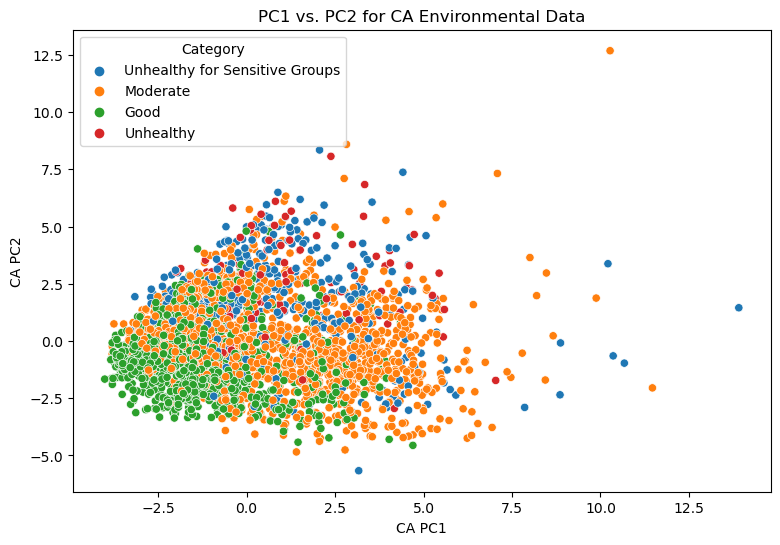

In [39]:
plt.figure(figsize = (9, 6))
plt.title("PC1 vs. PC2 for CA Environmental Data")
plt.xlabel("CA PC1")
plt.ylabel("CA PC2")
sns.scatterplot(x = ca_2d[:, 0], y = ca_2d[:, 1], hue = ca_target);

Based on this plot, it looks like the categories are clustered but not in an obvious way. It appears as if PC2 divides the hazard groups. Negative PC2 means more healthy and postive PC2 means less healthy. PC1 has a suprisingly unclear meaning with regards to category.

## 3.2 Make a Scree plot

In [40]:
ca_total_variance = sum(np.var(ca_standardized, axis=0))

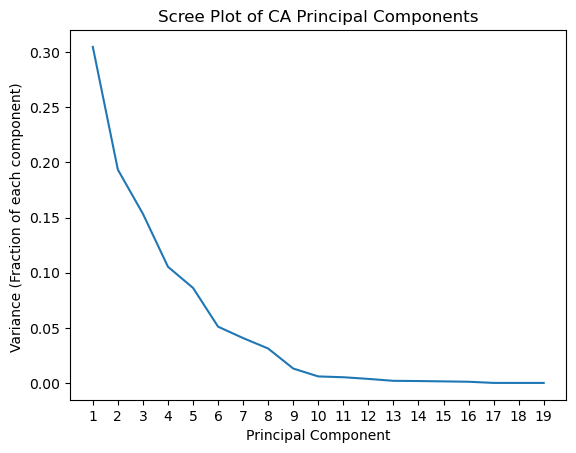

In [41]:
# your plot here
plt.xticks(list(range(1,20)))
plt.xlabel("Principal Component")
plt.ylabel("Variance (Fraction of each component) ")
plt.title("Scree Plot of CA Principal Components")
plt.plot(list(range(1,20)),(np.square(s)/ca_standardized.shape[0])/ca_total_variance)
plt.show()

In [42]:
variances =(np.square(s)/ca_standardized.shape[0])/ca_total_variance
first_ten_pcs_var = sum(variances[:10])
# first_ten_pcs_var

From this plot we can see that the first principal component makes up 30% of the variance and the second makes up about 19% of the variance. This means the first two principal components make up 49% of the variance. The first 10 principal components make up about 98% of the variance. Given this, it might be good to limit our model to 10 of these 19 features.

Latitude -0.05864950991373205
Longitude 0.13291997528012806
AQI_no2 0.9215192846454128
Arithmetic Mean_no2 0.914078253002463
1st Max Value_no2 0.9201454734019591
AQI_co 0.8723398104912571
Arithmetic Mean_co 0.8637213762713539
1st Max Value_co 0.8776787272023444


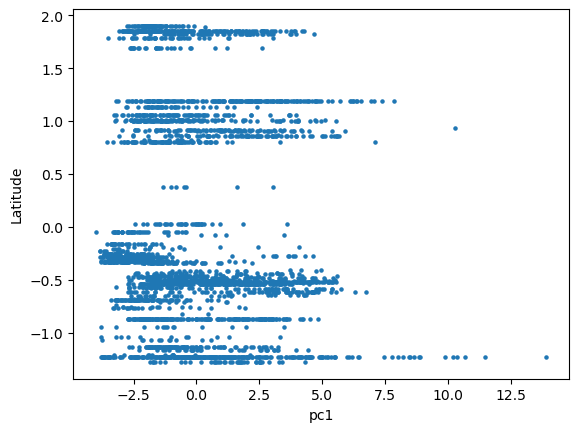

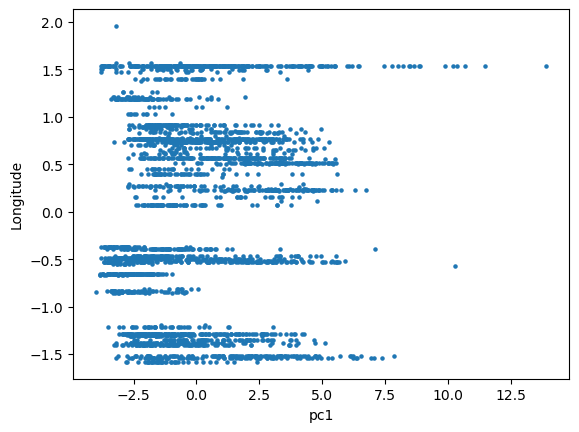

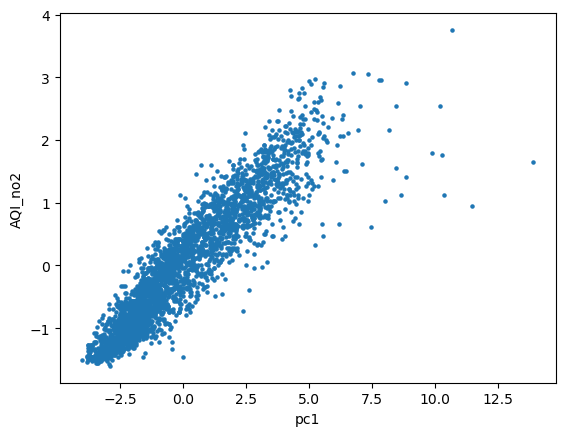

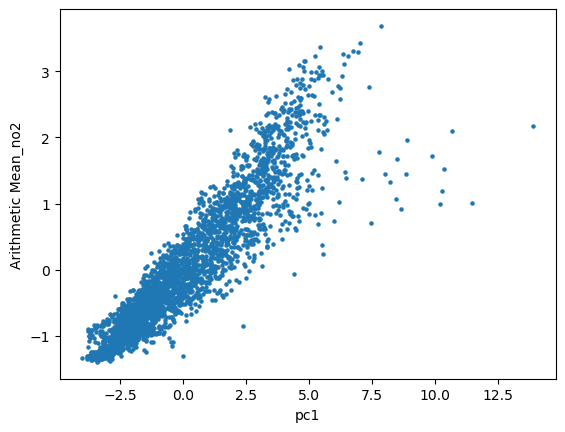

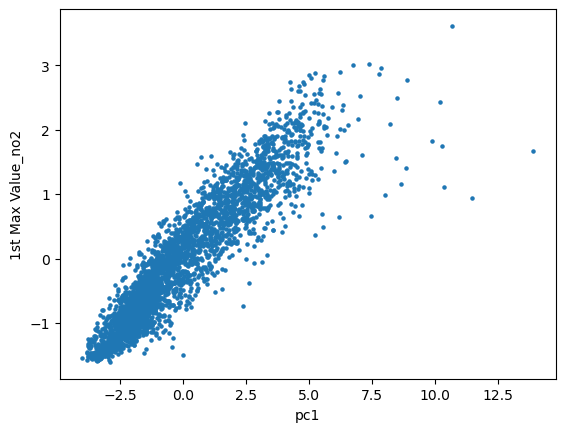

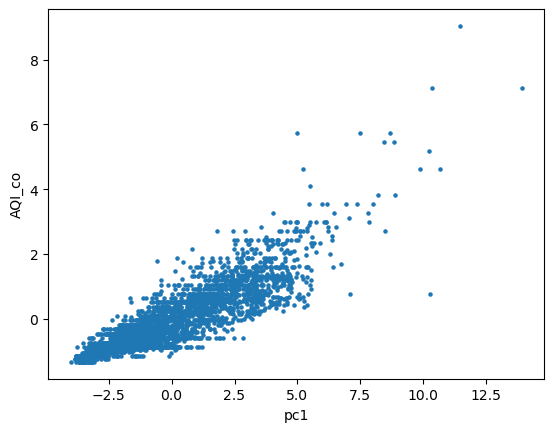

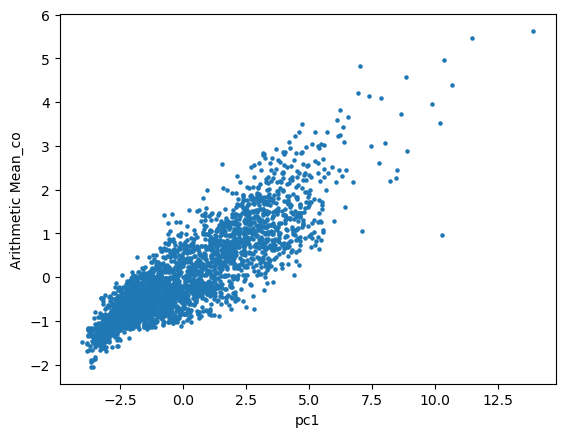

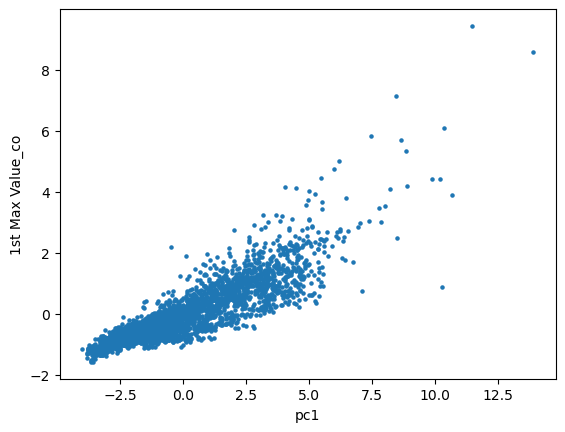

In [43]:
##This cell prints out the correlation coefficient between pc1 and each feature in the order of: 
# ['Latitude','Longitude','AQI_so2','Arithmetic Mean_so2','1st Max Value_so2','AQI_no2','Arithmetic Mean_no2',
#  '1st Max Value_no2','AQI_co','Arithmetic Mean_co','1st Max Value_co','AQI_ozone','Arithmetic Mean_ozone','1st Max Value_ozone',
#  'Arithmetic Mean_temp','1st Max Value_temp','Arithmetic Mean_wind','1st Max Value_wind']
first_2_pcs = pd.DataFrame(u[:,0:2]*s[0:2], columns = ['pc1','pc2'])
# point_names = list(ca_whole['County Name']) 
# first_2_pcs['point'] = point_names
cols = ca_standardized.columns.to_list()
valid_l = [1,2,6,7,8,9,10,11]
for i in range(len(cols)):
    col = cols[i]
    if i in valid_l:
        plt.figure()
        plt.scatter(first_2_pcs['pc1'],ca_standardized[col],s=5)
        plt.ylabel(col)
        plt.xlabel('pc1')
        print(col, np.corrcoef(first_2_pcs['pc1'],ca_standardized[col])[0,1])
# for col in cols:
#     plt.figure()
#     plt.scatter(first_2_pcs['pc1'],ca_standardized[col],s=5)
#     plt.ylabel(col)
#     plt.xlabel('pc1')
#     print(col, np.corrcoef(first_2_pcs['pc1'],ca_standardized[col])[0,1])

The covariance of two numbers tells us the extent that they vary with each other. It seems that latitude and longitude do not vary significantly with PC1. Features 'AQI_no2','Arithmetic Mean_no2','1st Max Value_no2','AQI_co','Arithmetic Mean_co','1st Max Value_co' do seem to vary significantly in the same direction as PC1 with correlation coefficients greater thant .80, where 1 would be the most correlated. Therefore we think it would be good to include a metric for co and no2 in our model. However, we are skeptical that each of these co and no2 metrics are necessary and believe only one for each gas would make sense. Furthermore, visually it appears that 'AQI_co' 'Arithmetic mean_co', '1st Max Value_co', '1st max Value_no2', 'Arithmetic Mean_no2', 'AQI_no2' all have linear relationships with PC1, which confirms our analysis of the correlation coefficient.

# 4. Linear Regression Model

In the following section, we implement a Linear Regression model to predict AQI using features mentioned above. After feature engineering and previous EDA, we now know that month, location, and features like "AQI_CO" potentially contribute most to AQI. 

In [44]:
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import zscore

## 4.1 Train-test split

In [45]:
ca_whole = pd.read_csv('ca_whole.csv',index_col=0)
# predictors = ca_whole.drop(columns=['County Name', 'Date Local','AQI', 'Category'])
predictors = ca_whole.drop(columns=['County Name', 'Date Local','AQI', 'Category','Month'])
# predictors_standard = standard_unit(predictors)
observed = ca_whole['AQI']

random_state = 42
#X = predictors_standard
X = predictors
y = observed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## 4.2 LM before removing outliers

We then fit the model with X_train and y_train. The training RMSE is approximately at 22, and the test RMSE is roughly the same.

In [46]:
# fit the linear model and make predictions
lm_model = lm.LinearRegression(fit_intercept=True)
y_fitted = lm_model.fit(X_train, y_train).predict(X_train)
y_predicted = lm_model.fit(X_train, y_train).predict(X_test)

# compute RMSE on train and test sets
train_rmse = mean_squared_error(y_train, y_fitted, squared=False)
test_rmse = mean_squared_error(y_test, y_predicted, squared=False)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 22.9724
Test RMSE: 18.4821


We then plot the residuals to further inspect the data. The residuals seem random enough so that our model does not overfit or underfit the data.

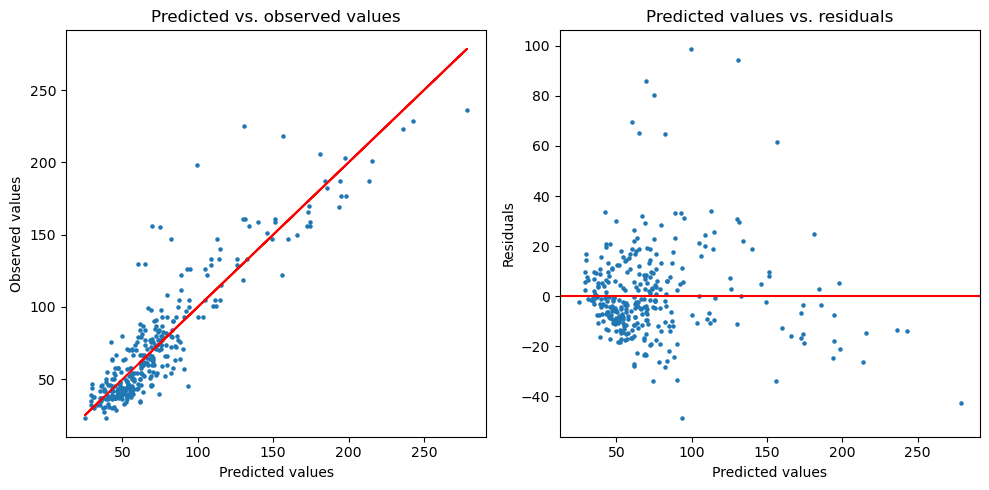

In [47]:
plt.figure(figsize=(10,5))      

plt.subplot(121)               
# (1) predictions vs observations
plt.scatter(y_predicted, y_test, s=5)
plt.plot(y_predicted, y_predicted, linestyle='-', color='r')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.title('Predicted vs. observed values')

plt.subplot(122)               
# (2) residual plot
plt.scatter(y_predicted, y_test-y_predicted, s=5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Predicted values vs. residuals')

plt.tight_layout()             

## 4.3 LM after removing outliers

In [48]:
# Drop Outlier
max_aqi = np.mean(ca_whole['AQI'])+2*np.std(ca_whole['AQI'])
min_aqi = np.mean(ca_whole['AQI'])-2*np.std(ca_whole['AQI'])
ca_whole_no_outlier = ca_whole.loc[ca_whole['AQI']<=max_aqi]

In [49]:
# predictors = ca_whole_no_outlier.drop(columns=['County Name', 'Date Local','AQI', 'Category'])
predictors = ca_whole_no_outlier.drop(columns=['County Name', 'Date Local','AQI', 'Category','Month'])
observed = ca_whole_no_outlier['AQI']


X = predictors
y = observed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

The training RMSE decreases down to around 17 after removing outliers.

In [50]:
# fit the linear model and make predictions
lm_model = lm.LinearRegression(fit_intercept=True)
y_fitted = lm_model.fit(X_train, y_train).predict(X_train)
y_predicted = lm_model.fit(X_train, y_train).predict(X_test)

# compute RMSE on train and test sets
train_rmse = mean_squared_error(y_train, y_fitted, squared=False)
test_rmse = mean_squared_error(y_test, y_predicted, squared=False)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 17.0322
Test RMSE: 17.4811


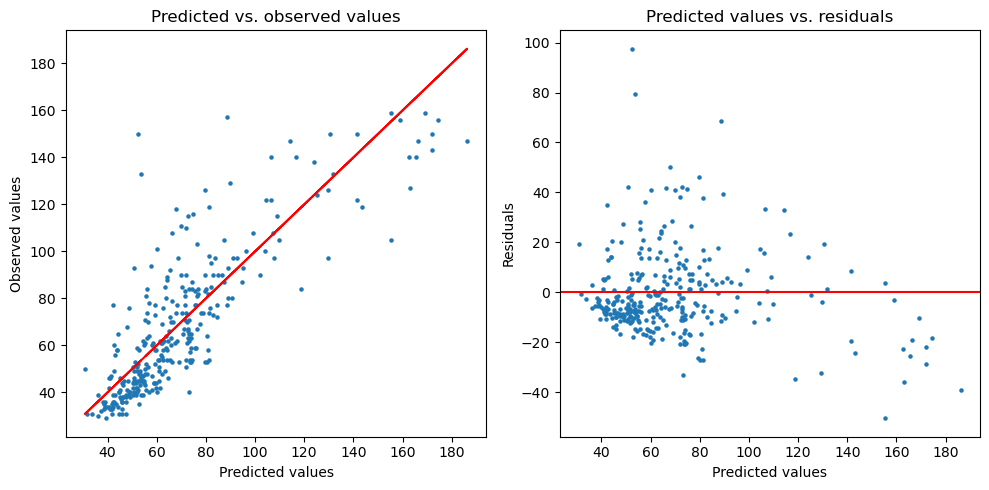

In [51]:
plt.figure(figsize=(10,5))      

plt.subplot(121)               
# (1) predictions vs observations
plt.scatter(y_predicted, y_test, s=5)
plt.plot(y_predicted, y_predicted, linestyle='-', color='r')
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.title('Predicted vs. observed values')

plt.subplot(122)               
# (2) residual plot
plt.scatter(y_predicted, y_test-y_predicted, s=5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Predicted values vs. residuals')

plt.tight_layout()             

## 4.4 Residual heatmap

In [52]:
def get_gdf(X_train, y_train, y_fitted, ml):
    gdf = X_train.loc[:,['Latitude', 'Longitude']].copy()
    if ml == False:
        gdf['Residual'] = (y_fitted - y_train).abs()
    else: 
        gdf['Residual'] = np.abs(y_fitted - y_train)
    return gdf

In [53]:
gdf = get_gdf(X_train, y_train, y_fitted, False)

We then plot the residuals on the map. Darker colors represent lower absolute residuals whereas lighter ones are greater absolute residuals. It seems that our predictions of AQI for coastal counties have higher accuracy whereas our predictions of most southern california counties have low accuracy.

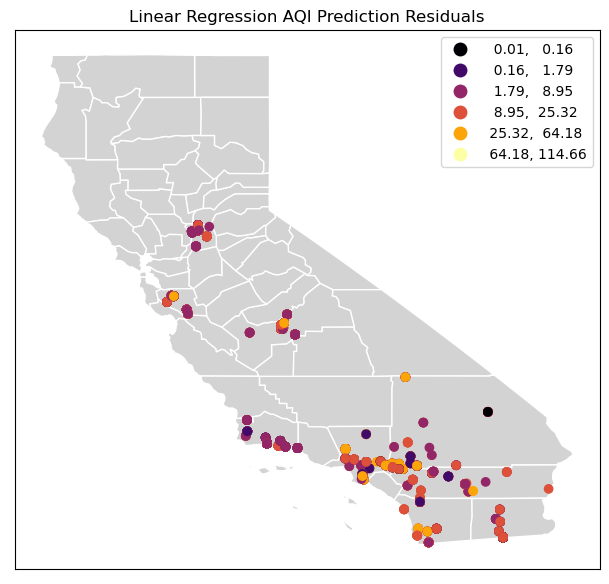

In [54]:
# heatmap(gdf, False)
title = "Linear Regression AQI Prediction Residuals"
heatmap_cl(gdf,title,True, False)

# Machine Learning Model

### 1.Import Modules

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split
import geopandas as gpd
import torch
import torch.nn as nn
import torch.nn.functional as fun
import seaborn as sns

### 2.Read Data and Process Data

In [56]:
ca_whole_ml = pd.read_csv('ca_whole.csv',index_col=0)

Drop Outlier to avoid influence from Outliers

In [57]:
max_aqi_ml = np.mean(ca_whole_ml['AQI'])+2*np.std(ca_whole_ml['AQI'])
min_aqi_ml = np.mean(ca_whole_ml['AQI'])-2*np.std(ca_whole_ml['AQI'])
ca_whole_ml = ca_whole_ml.loc[ca_whole_ml['AQI']<=max_aqi_ml]

Split X and y

In [58]:
y_ml = ca_whole_ml.loc[:,['AQI']]
X_ml= ca_whole_ml.drop(columns = ['County Name', 'Date Local','Category','AQI','Month'])

Split Data for Train(0.9) and Test(0.1)

In [59]:
X_train_ml_np, X_test_ml_np, y_train_ml_np, y_test_ml_np = train_test_split(X_ml, y_ml, test_size=0.1)
X_train_ml = torch.tensor(X_train_ml_np.values.astype(np.float32))
X_test_ml = torch.tensor(X_test_ml_np.values.astype(np.float32))
y_train_ml = torch.tensor(y_train_ml_np.values.astype(np.float32))
y_test_ml = torch.tensor(y_test_ml_np.values.astype(np.float32))

### 3.Create Model

In [60]:
# One Hidden Layer of Fully Connected Model
class mlmodel(nn.Module):
    def __init__(self):
        super(mlmodel, self).__init__()
        self.fc1   = nn.Linear(18, 10)
        self.fc2  = nn.Linear(10, 1)
            
    def forward(self, y):
        y = fun.relu(self.fc1(y))
        y = self.fc2(y)
        return y
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

### 4.Validation for Learning Rate

In [61]:
valid_rmse = [None] * 6
learning_rates = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

for i in range(len(learning_rates)):
    rmse = 0
    learning_rate = learning_rates[i]
    for j in range(5):
        model = mlmodel()
        # Set up valid train sets
        X_valid_train, X_valid, y_valid_train, y_valid = train_test_split(X_train_ml, y_train_ml, test_size=0.2)
        for t in range(4000):
            # Forward pass
            model.eval()
            y_pred = model(X_valid_train)

            # Compute loss.
            loss = RMSELoss(y_pred, y_valid_train)
            # Zero gradients
            model.zero_grad()

            # Backward pass
            loss.backward()

            # Update weights
            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad
        # Calculate validation rmse
        y_pred = model(X_valid)
        rmse = (rmse + RMSELoss(y_pred, y_valid).item())/5
    # Store validation rmse
    valid_rmse[i] = rmse
valid_rmse

[8.348886517944337,
 8.401879802856445,
 11.836900231933594,
 5.644622430419922,
 4.694268774414063,
 6.585738012695313]

In [62]:
learning_rate = learning_rates[valid_rmse.index(np.min(valid_rmse))]
learning_rate

0.0001

By using validation, we could find out that learning rate $=0.0001$ could provide us with the minimum learning rate. So, we will use learning rate $=0.0001$ for the rest training 

### 5.Train

In [63]:
model_ml = mlmodel()
train_loss_ml = [None]*20000
test_loss_ml = [None]*20000
for t in range(20000):
    # Forward pass
    model_ml.eval()
    y_pred_ml = model_ml(X_train_ml)

    # Compute loss.
    loss_ml = RMSELoss(y_pred_ml, y_train_ml)
    # Store Loss
    train_loss_ml[t] = loss_ml.item()
    test_loss_ml[t] = RMSELoss(model_ml(X_test_ml), y_test_ml).item()
    
    # Zero the gradients.
    model_ml.zero_grad()
    
    # Backward pass
    loss_ml.backward()

    # Update weights
    with torch.no_grad():
        for param in model_ml.parameters():
            param -= learning_rate * param.grad

### 6.Plots and Analysis of the Result

#### 6.1 RMSE vs Training Time

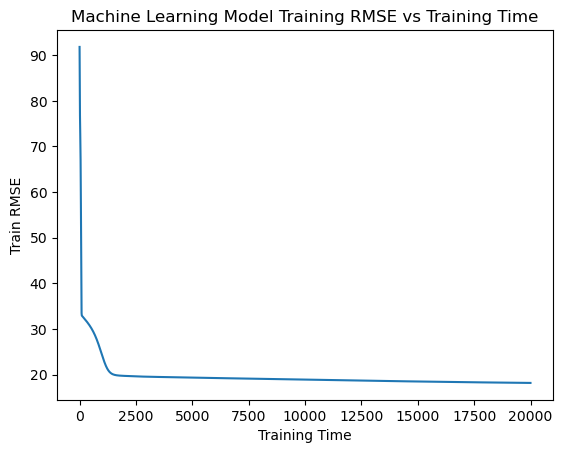

In [64]:
x_ml = np.arange(20000)
plt.plot(x_ml,train_loss_ml)
plt.title("Machine Learning Model Training RMSE vs Training Time")
plt.xlabel("Training Time")
plt.ylabel("Train RMSE")
plt.show()

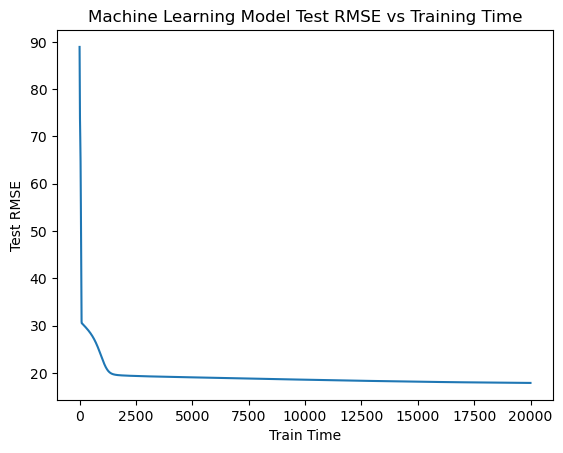

In [65]:
plt.plot(x_ml,test_loss_ml)
plt.title("Machine Learning Model Test RMSE vs Training Time")
plt.xlabel("Train Time")
plt.ylabel("Test RMSE")
plt.show()

In [66]:
print(train_loss_ml[-1])
print(test_loss_ml[-1])

18.195486068725586
17.868053436279297


It is clear that with the training time increase, both the Train RMSE and Test RMSE decreaseses. Note that both the Train RMSE and Test RMSE stop decrease dramatically after $2500$ epoches.

#### 6.2 Residual Analysis

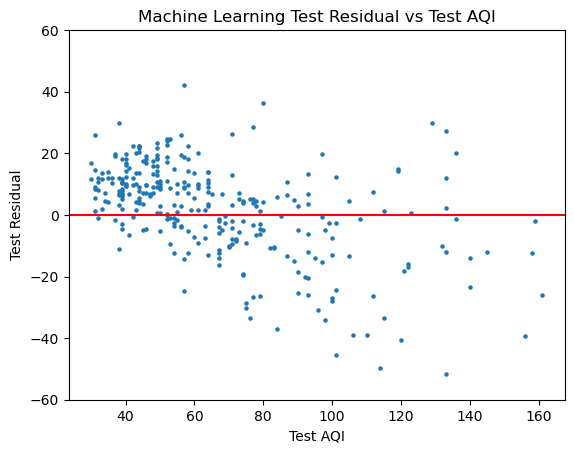

In [67]:
y_pred_ml = model_ml(X_test_ml)
residual_train_ml = y_pred_ml - y_test_ml
plt.scatter(y_test_ml.detach().numpy(), residual_train_ml.detach().numpy(), s=5)
plt.axhline(0, color ='Red')
plt.title("Machine Learning Test Residual vs Test AQI")
plt.xlabel("Test AQI")
plt.ylabel("Test Residual")
plt.ylim([-60,60])
plt.show()

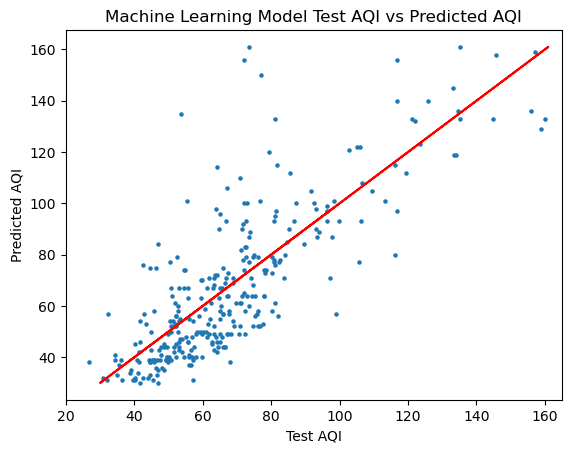

In [68]:
plt.scatter(y_pred_ml.detach().numpy(), y_test_ml.detach().numpy(),s=5)
plt.plot(y_test_ml.detach().numpy(),y_test_ml.detach().numpy(), color='red')
plt.title("Machine Learning Model Test AQI vs Predicted AQI")
plt.xlabel("Test AQI")
plt.ylabel("Predicted AQI")
plt.xlim([20, 165])
plt.show()

The distribution of Test RMSE and Test AQI is random enough that we could say over model does not either underfit or overfit the data.

The distribution of Test AQI vs Predict AQI also support this conclusion.

The ML model is not influenced by the value of Test AQI.

#### 6.3 Heat Map Residual

In [69]:
def get_gdf(X_train, y_train, y_fitted, ml):
    gdf = X_train.loc[:,['Latitude', 'Longitude']].copy()
    if ml == False:
        gdf['Residual'] = (y_fitted - y_train).abs()
    else: 
        gdf['Residual'] = np.abs(y_fitted - y_train)
    return gdf

In [70]:
gdf_ml_test = get_gdf(X_test_ml_np,y_test_ml.detach().numpy(),y_pred_ml.detach().numpy(), True)
gdf_ml_test.to_csv("ml_test_residual.csv")

In [71]:
y_pred_train_ml = model_ml(X_train_ml)
gdf_ml_train = get_gdf(X_train_ml_np,y_train_ml.detach().numpy(),y_pred_train_ml.detach().numpy(), True)
gdf_ml_train.to_csv("ml_train_residual.csv")

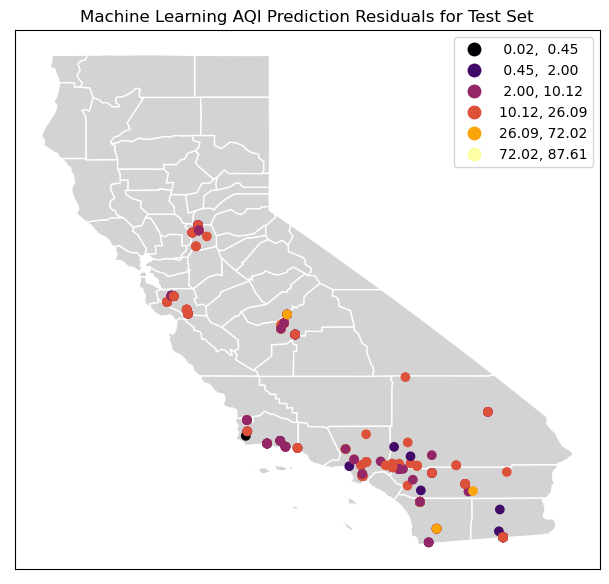

In [72]:
gdf_ml_test = pd.read_csv("ml_test_residual.csv", index_col = 0)
# heatmap(gdf_ml_test, False)
title = "Machine Learning AQI Prediction Residuals for Test Set"
heatmap_cl(gdf_ml_test,title,True, False)

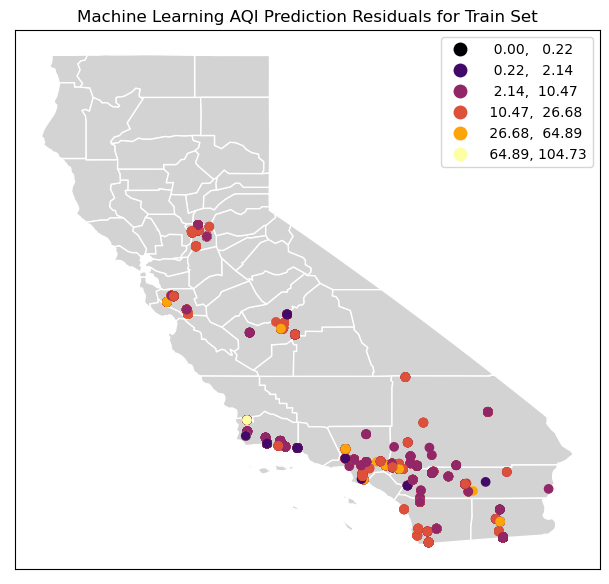

In [73]:
gdf_ml_train = pd.read_csv("ml_train_residual.csv", index_col = 0)
# heatmap(gdf_ml_train, False)
title = "Machine Learning AQI Prediction Residuals for Train Set"
heatmap_cl(gdf_ml_train,title,True, False)

By viewing the two heatmaps above. There is no pattern between residual and location.

# Discussion

Our models did a reasonably good job at predicting AQI for the nine counties that were used in our training data. By comparing the result of both Linear Regression and ML model, we could find that : 
1. Both of them reaches ~17 for train RMSE, ~17 for test RMSE. 
2. Both has a random residual plot, which means there is no need to use the Tukey-Mosteller Bulge Diagram to improve the models.

However, this contradicts our expectation that ML model will have a better result than the Linear Regression Model. Here are 2 hypotheses that may cause this issue: 
1. There might be some other characteristics that also have influence to AQI, but those characteristics are not included in our datasets. In this hypothesis, ~17 for train RMSE and ~17 for test RMSE are the upperbonds predictions that we could make with current datasets. It makes sense that the ML model does not have a better prediction than the linear regression model, since both models met the upperbonds.
2. Our ML model might not be complicated enough to capture a deep relationship between current characteristics. Because the dataset is not large enough(around 3,000 data points), and we only have 18 features for each data point, we chose a simple design to avoid overfitting. In our design, we chose the ML model to have only 1 hidden layer with 10 hidden nodes, and we also chose to use the fully conntected neural networks. By viewing the graph of Train/Test Loss vs training epoches, we could not find any sign of overfitting (i.e. an increase in Test loss) even if we let the model train for 20,000 epoches. This is evidence that our ML model is not complicated enough to fit the data.

In the future, we might implement the following to improve the model:
1. Collect more related data about AQI, and try to run PCA or other analysis methods on them to find out potential characteristics that may influence AQI.
2. Try to use deep neural networks with optimization.

# Supplementary Analysis

## Logistic Regression Model

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

In [90]:
#create var names again from PCA
ca_target = ca_whole['Category']
ca_features = ca_whole.drop(columns = ['County Name', 'Date Local','Category','AQI','Month'])
ca_feature_names = ca_features.columns
#make standardized
ca_standardized = (ca_features - np.mean(ca_features,axis=0))/np.std(ca_features)

In [91]:
feature_means = np.mean(ca_features)
feature_stds = np.std(ca_features)

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(ca_standardized,ca_target, test_size=0.1)

In [93]:
shortened = ca_standardized.loc[:,['Latitude','Longitude','Arithmetic Mean_co','Arithmetic Mean_so2','Arithmetic Mean_so2','Arithmetic Mean_ozone','Arithmetic Mean_temp','Arithmetic Mean_wind']]

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(shortened,ca_target, test_size=0.1)

In [95]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(fit_intercept=True,solver='lbfgs')

lr.fit(X_train,Y_train)
train_predictions = lr.predict(X_train)#wasn't able to predict with all columns, but now able to predict

In [96]:
train_accuracy = np.mean((Y_train==lr.predict(X_train)).astype(int))
test_accuracy =  np.mean((Y_test==lr.predict(X_test)).astype(int))

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Train accuracy: 0.6850
Test accuracy: 0.7037


In [97]:
Y_test_pred = lr.predict(X_test)
(Y_test==lr.predict(X_test)).astype(int)
n_tp = ((Y_test==Y_test_pred) &(Y_test_pred == 'Unhealthy')).value_counts().loc[True]
n_fp = ((Y_test!=Y_test_pred) &(Y_test_pred == 'Unhealthy')).value_counts().loc[True]
n_fn = ((Y_test!=Y_test_pred) &(Y_test_pred == 'Good')).value_counts().loc[True]
precision = n_tp/(n_fp+n_tp)
recall = n_tp/(n_fn+n_tp)

print(f'precision = {precision:.4f}')
print(f'recall = {recall:.4f}')

precision = 0.7895
recall = 0.4545


It looks like Unhealthy versus Good recall is very low. Recall is the fraction of true positives (here where we correctly identify Unhealthy AQI conditions) among the total number of data points with positive label (Unhealthy label).
But our precision is much higher (still not good). Precision is the fraction of true positives among the total number of data points predicted as positive. A high precision means that false positives are minimized. We can also test the accuracy of the category prediction through side-by-side plots of the true vs predicted values.

In [98]:
#plot predicted category
training_true = X_train.copy()
training_true['Category'] = Y_train
#map category to random aqi
nmbs=[45,95,145,195,295,600] 
levels_dict = {levelsOfConcern[i]: nmbs[i] for i in range(len(levelsOfConcern))}
training_true['sudo_aqi'] = training_true['Category'].map(levels_dict)
training_predict = X_train.copy()
training_predict['Category'] = train_predictions
training_predict['sudo_aqi'] = training_predict['Category'].map(levels_dict)

In [99]:
#training_true
#got to put back in mean and std
gdf_logistic_true = gpd.GeoDataFrame(
    training_true, 
    geometry=gpd.points_from_xy((training_true.Longitude*feature_stds['Longitude'])+feature_means['Longitude'], 
                                (training_true.Latitude*feature_stds['Latitude'])+feature_means['Latitude'])
)

# gdf_logistic_true
##training predict
gdf_logistic_predict = gpd.GeoDataFrame(
    training_predict, 
    geometry=gpd.points_from_xy((training_predict.Longitude*feature_stds['Longitude'])+feature_means['Longitude'], 
                                (training_predict.Latitude*feature_stds['Latitude'])+feature_means['Latitude'])
)


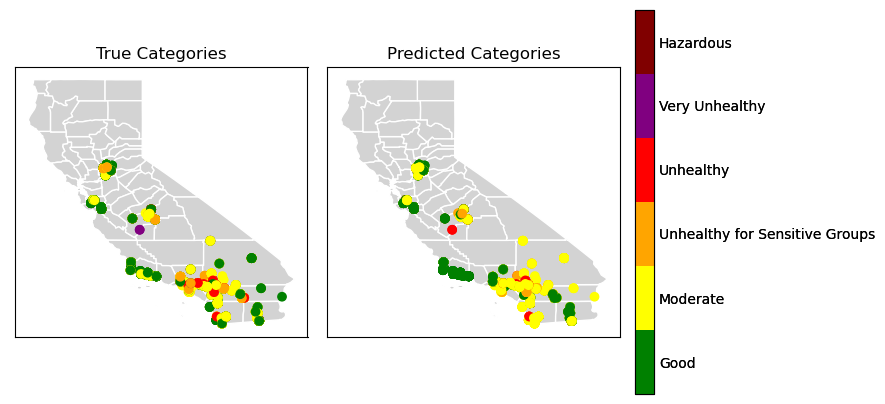

In [100]:
from matplotlib import pyplot
fig, (ax1,ax2) = pyplot.subplots(ncols=2,sharex=True,sharey=True)

#true
states =['California']
usa = gpd.read_file("https://raw.githubusercontent.com/danhammer/envirods/main/data/gz_2010_us_040_00_20m.geojson")
state_gdf = usa[usa.NAME.isin(states)]


# fig, ax = plt.subplots()
geoData.plot(
    ax=ax1,
    column='AQI',color='lightgrey',edgecolor='white');
from matplotlib import colors
#make a color map of fixed colors
cmap = colors.ListedColormap(['Green','Yellow','Orange','Red','Purple','Maroon'])
bounds = [0,50,100,150,200,300,2000]
norm = colors.BoundaryNorm(bounds,cmap.N)

gdf_logistic_true.plot(ax=ax1,column=gdf_logistic_true.sudo_aqi,cmap = cmap,norm=norm,legend=False);
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.set_ticks([bounds[0]] + [(b0 + b1) / 2 for b0, b1 in zip(bounds[:-1], bounds[1:])] + [bounds[-1]])
tick_texts = cbr.ax.set_yticklabels(levelsOfConcern_cbr)
tick_texts[0].set_verticalalignment('top')
tick_texts[-1].set_verticalalignment('bottom')
cbr.ax.tick_params(length=0) # optionally remove the tick marks

# plt.subplot(1,2,2)
###Predicted on training

states =['California']
usa = gpd.read_file("https://raw.githubusercontent.com/danhammer/envirods/main/data/gz_2010_us_040_00_20m.geojson")
state_gdf = usa[usa.NAME.isin(states)]

# fig, ax = plt.subplots(figsize=(15,10))
# fig, ax = plt.subplots()
geoData.plot(
    ax=ax2,
    column='AQI',color='lightgrey',edgecolor='white');
from matplotlib import colors
#make a color map of fixed colors
cmap = colors.ListedColormap(['Green','Yellow','Orange','Red','Purple','Maroon'])
bounds = [0,50,100,150,200,300,2000]
norm = colors.BoundaryNorm(bounds,cmap.N)

gdf_logistic_predict.plot(ax=ax2,column=gdf_logistic_predict.sudo_aqi,cmap = cmap,norm=norm,legend=False,label = 'Prediction');
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)
cbr.set_ticks([bounds[0]] + [(b0 + b1) / 2 for b0, b1 in zip(bounds[:-1], bounds[1:])] + [bounds[-1]])
tick_texts = cbr.ax.set_yticklabels(levelsOfConcern_cbr)
tick_texts[0].set_verticalalignment('top')
tick_texts[-1].set_verticalalignment('bottom')
cbr.ax.tick_params(length=0) # optionally remove the tick marks

ax1.set_title('True Categories')
ax2.set_title('Predicted Categories')
plt.tight_layout()
plt.show()

Logistical regression could be an alternative way to predict the level of concern of AQI without needing as precise AQI prediction values. However, inaccuracies in all three models seem to occur in similar regions. The regions that have incorrect predicted categories correspond with the regions that had high residuals in the linear regression and machine learning models.